<a href="https://colab.research.google.com/github/maxrgnt/pythdc2-project2/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Panel Data
import pandas as pd
# System folders
import os
from pathlib import Path
# Visualization
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline

In [126]:
url = 'https://raw.githubusercontent.com/maxrgnt/pythdc2-project2/master/data/unemployment.csv'
bls = pd.read_csv(url)
print(bls.shape)
bls.sample(1)

(322, 5)


,State,Year,Abrv,UnemploymentRate,LaborRate
193,Texas,2009,TX,0.081924,0.658382


In [127]:
url = 'https://raw.githubusercontent.com/maxrgnt/pythdc2-project2/master/data/pctChangeGDP.csv'
bea = pd.read_csv(url)
print(bea.shape)
bea.sample(1)

(322, 4)


,State,Abrv,Year,Value
117,Michigan,MI,2004,2.0


In [128]:
# read in the data
url='https://raw.githubusercontent.com/maxrgnt/pythdc2-project2/master/data/borderCrossing.csv'
bts = pd.read_csv(url)
print(bts.shape)
bts.sample(1)

(114588, 8)


,Abrv,State,Longitude,Latitude,Border,Year,Measure,Value
269,WA,Washington,-122.44316,48.94802,US-Canada Border,2018,Bus Passengers,93


In [0]:
def checkPctChange(df):
  print(df[(df['Abrv']=='TX') & (df['Year']==2014)])
  print(df[(df['Abrv']=='TX') & (df['Year']==2015)])
  print(df[(df['Abrv']=='TX') & (df['Year']==2016)])

In [0]:
def calcPctChange(df, col, pctChange_id):
  for y in list(df['Year'].unique()):
    states = list(df['Abrv'].unique())
    for s in states:
      if y != df['Year'].min():
        t0 = df.loc[(df['Year'] == y-1) & (df['Abrv'] == s), col].tolist()[0]
        t1 = df.loc[(df['Year'] == y) & (df['Abrv'] == s), col].tolist()[0]
        df.loc[(df['Year']==y) & (df['Abrv']==s), pctChange_id+'_pctChange'] = ((t1/t0)-1)*100
      else:
        df.loc[(df['Year']==y) & (df['Abrv']==s), pctChange_id+'_pctChange'] = 'N/A'
  # set drop index for first year where pctChange not calculated
  dropIndex = df.loc[df[pctChange_id+'_pctChange']=='N/A'].index
  df.drop(dropIndex, inplace=True)

In [139]:
bts2 = bts.groupby(['Year','Abrv'])[['Value']].sum().reset_index()
bts2.sample(1)

,Year,Abrv,Value
233,2012,NM,1835195


In [140]:
calcPctChange(bts2, 'Value', 'border')
checkPctChange(bts2)

(322, 4)
(308, 4)
     Year Abrv     Value border_pctChange
263  2014   TX  80334766          4.71749
     Year Abrv     Value border_pctChange
277  2015   TX  82726100          2.97671
     Year Abrv     Value border_pctChange
291  2016   TX  85714503          3.61241


In [152]:
bea.rename(columns={'Value':'gdp_pctChange'},inplace = True)
checkPctChange(bea)

     State Abrv  Year  gdp_pctChange
263  Texas   TX  2014            4.2
     State Abrv  Year  gdp_pctChange
277  Texas   TX  2015            0.2
     State Abrv  Year  gdp_pctChange
291  Texas   TX  2016           -0.2


In [153]:
calcPctChange(bls, 'UnemploymentRate', 'unemp')
checkPctChange(bls)

(308, 6)
(294, 6)
     State  Year Abrv  UnemploymentRate  LaborRate unemp_pctChange
263  Texas  2014   TX          0.053764    0.64867        -19.4988
     State  Year Abrv  UnemploymentRate  LaborRate unemp_pctChange
277  Texas  2015   TX          0.046521   0.637932        -13.4719
     State  Year Abrv  UnemploymentRate  LaborRate unemp_pctChange
291  Texas  2016   TX          0.048399   0.637718         4.03763


In [170]:
df = df[df['Abrv']=='TX']
df = bls[['Year','Abrv','unemp_pctChange']].merge(bea[['Year','Abrv','gdp_pctChange']], how = 'left', left_on=['Year','Abrv'], right_on=['Year','Abrv'],sort=True)
df = df.merge(bts2[['Year','Abrv','border_pctChange']], how = 'left', left_on=['Year','Abrv'], right_on=['Year','Abrv'],sort=True)
df['Year'] = df['Year'].astype(float)
df['border_pctChange'] = df['border_pctChange'].astype(float)
df['gdp_pctChange'] = df['gdp_pctChange'].astype(float)
df['unemp_pctChange'] = df['unemp_pctChange'].astype(float)
df_melt = df.melt(['Year','Abrv'], var_name='cols', value_name='vals')
df_melt.sample(3)

,Year,Abrv,cols,vals
62,2002.0,MN,unemp_pctChange,20.144918
68,2002.0,VT,unemp_pctChange,21.373792
43,2001.0,AZ,unemp_pctChange,22.077542


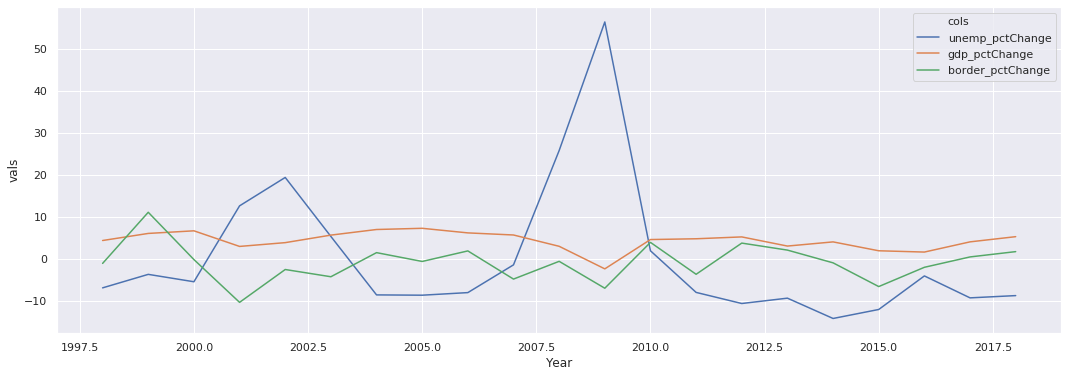

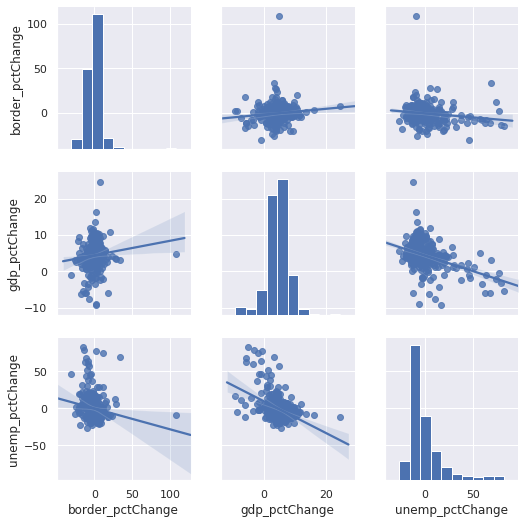

In [180]:
sns.set(rc={'figure.figsize':(18,6)})
sns.lineplot(x = 'Year', y = 'vals', hue = 'cols', ci=None, data = df_melt);
sns.pairplot(df, vars=['border_pctChange','gdp_pctChange','unemp_pctChange'], kind='reg');

In [0]:
# mapbox_access_token = open("assets/mytoken.mapbox_token").read()

# fig = go.Figure(go.Scattermapbox(
#     lat=df['Latitude'],
#     lon=df['Longitude'],
#     mode='markers',
#     marker=go.scattermapbox.Marker(
#         size=20,
#         colorscale='Purples',
#         color=df['Value']
#     ),
#     text=df['Value']

# ))
# fig.update_layout(
#     autosize=True,
#     hovermode='closest',
#     mapbox=go.layout.Mapbox(
#         accesstoken=mapbox_access_token,
#         bearing=0,
#         center=go.layout.mapbox.Center(
#             lat=39.8283,
#             lon=-98.5795
#         ),
#         pitch=0,
#         zoom=3
#     ),
# )
# fig

In [0]:
# fig = go.Figure(data=go.Choropleth(
#     locations=df2['StateAbrv'], # Spatial coordinates
#     z = df2['Value'].astype(float), # Data to be color-coded
#     locationmode = 'USA-states', # set of locations match entries in `locations`
#     colorscale = 'Purples',
#     colorbar_title = "Pedestrians",
# ))

# fig.update_layout(
#     title_text = 'Migration',
#     geo_scope='usa', # limite map scope to USA
# )

# fig.show()